# Generational changes in religious attitudes

Allen Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [1]:
from __future__ import print_function, division

%matplotlib inline

import pandas as pd
import numpy as np

import thinkstats2
import thinkplot
import utils

import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style='whitegrid', font_scale=1.5)

from scipy.special import expit

Reading data from the [General Social Survey](https://gssdataexplorer.norc.org/projects/29853)

In [2]:
# !wget https://gssdataexplorer.norc.org/extracts/21438/download

In [3]:
gss = utils.ReadGss('gss_religion_data')
print(gss.shape)
gss.head()

(62466, 11)


,year,conclerg,bible,cohort,age,wtssall,ballot,relig,educ,id_,god
0,1972,0,0,1949,23,0.4446,0,3,16,1,0
1,1972,0,0,1902,70,0.8893,0,2,10,2,0
2,1972,0,0,1924,48,0.8893,0,1,12,3,0
3,1972,0,0,1945,27,0.8893,0,5,17,4,0
4,1972,0,0,1911,61,0.8893,0,1,12,5,0


Cleaning variables

In [4]:
# TODO: find out what code 4 is

gss.bible.replace([4, 8, 9, 0], np.nan, inplace=True)

In [5]:
utils.values(gss, 'bible')

1.0    11185
2.0    15926
3.0     5929
Name: bible, dtype: int64

In [6]:
gss.conclerg.replace([8, 9, 0], np.nan, inplace=True)

In [7]:
utils.values(gss, 'conclerg')

1.0    11366
2.0    20886
3.0     8660
Name: conclerg, dtype: int64

In [8]:
gss.god.replace([8, 9, 0], np.nan, inplace=True)
sum(gss.god.isnull())

40129

In [9]:
utils.values(gss, 'god')

1.0      673
2.0     1110
3.0     2286
4.0      900
5.0     3662
6.0    13706
Name: god, dtype: int64

In [10]:
gss.age.replace([98, 99], np.nan, inplace=True)
sum(gss.age.isnull())

221

In [11]:
gss.cohort.replace([9999], np.nan, inplace=True)
sum(gss.cohort.isnull())

221

In [12]:
gss.relig.replace([98, 99], np.nan, inplace=True)
sum(gss.relig.isnull())

269

In [13]:
gss.dropna(subset=['age', 'cohort', 'relig'], inplace=True)
gss.shape

(61995, 11)

We drop 471 records due to missing data.

In [14]:
62466 - 61995

471

Here's the distribution of ages.

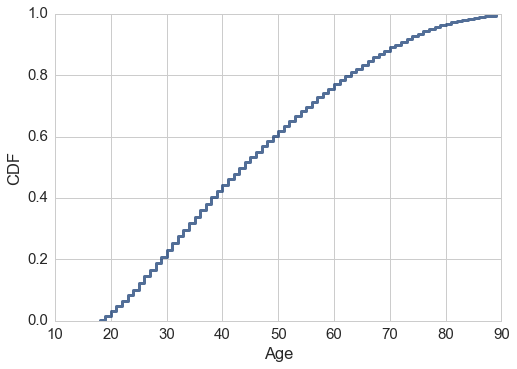

In [15]:
thinkplot.Cdf(thinkstats2.Cdf(gss.age))
thinkplot.Config(xlabel='Age', ylabel='CDF')

Group people into 5-year age groups.

In [16]:
gss['age_group'] = utils.RoundIntoBins(gss, 'age', 5) + 2.5

Here's the distribution of birth year.

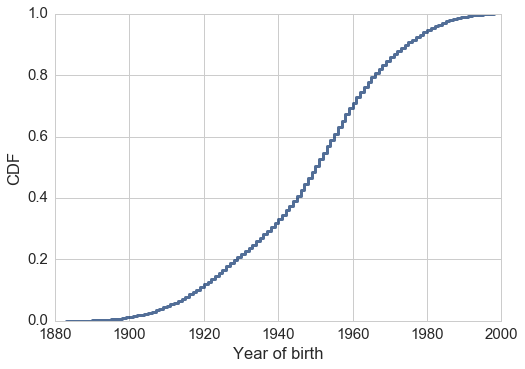

In [17]:
thinkplot.Cdf(thinkstats2.Cdf(gss.cohort))
thinkplot.Config(xlabel='Year of birth', ylabel='CDF')

Group people into 5- and 10-year bins by birth year.

In [18]:
gss['cohort5'] = utils.RoundIntoBins(gss, 'cohort', 5) + 2.5

In [19]:
gss['cohort10'] = utils.RoundIntoBins(gss, 'cohort', 10)

Here's the distribution of religion codes.

In [20]:
utils.values(gss, 'relig')

1.0     35856
2.0     15136
3.0      1233
4.0      7231
5.0      1064
6.0       177
7.0        88
8.0        38
9.0       135
10.0      112
11.0      760
12.0       30
13.0      135
Name: relig, dtype: int64

Resampling (bootstrapping to be more specific) to account for sampling weights.

In [21]:
sample = utils.ResampleByYear(gss)
sample.head()

,year,conclerg,bible,cohort,age,wtssall,ballot,relig,educ,id_,god,age_group,cohort5,cohort10
0,1972,NaN,NaN,1924.0,48.0,1.3339,0,1.0,6,1425,NaN,47.5,1922.5,1920.0
1,1972,NaN,NaN,1948.0,24.0,0.8893,0,1.0,14,450,NaN,22.5,1947.5,1940.0
2,1972,NaN,NaN,1950.0,22.0,3.5571,0,1.0,16,1382,NaN,22.5,1952.5,1950.0
3,1972,NaN,NaN,1938.0,34.0,0.8893,0,1.0,16,1551,NaN,32.5,1937.5,1930.0
4,1972,NaN,NaN,1914.0,58.0,1.3339,0,1.0,12,1368,NaN,57.5,1912.5,1910.0


## How does religious affiliation change with age?

In [22]:
varnames = ['prot', 'cath', 'none', 'other']

def create_relig_vars(df):
    """Creates columns for religious categories.
    
    df: DataFrame
    """
    # the second line lumps "Orthodox-Christian" and "Christian" with Protestant
    #df['prot'] = (df.relig==1)
    df['prot'] = (df.relig.isin([1,10,11]))

    df['cath'] = (df.relig==2)
    df['none'] = (df.relig==4)
    df['other'] = (df.relig.isin([3,5,6,7,8,9,12,13]))
    
    df['relig4'] = df.relig.copy()
    df.relig4.replace([10, 11], 1, inplace=True)
    df.relig4.replace([5,6,7,8,9,12,13], 3, inplace=True)

    df.loc[df.relig.isnull(), varnames + ['relig4']] = np.nan
    
create_relig_vars(sample)

Group by decade of birth and age group.

In [23]:
grouped = sample.groupby(['cohort10', 'age_group'])

Count the number of observations in each decade/age group.

In [24]:
counts = grouped.none.count().unstack()
counts

age_group,17.5,22.5,27.5,32.5,37.5,42.5,47.5,52.5,57.5,62.5,67.5,72.5,77.5,82.5,87.5
cohort10,,,,,,,,,,,,,,,
1880.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,38.0
1890.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.0,176.0,145.0,100.0
1900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.0,433.0,491.0,330.0,231.0,148.0
1910.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.0,603.0,732.0,708.0,623.0,484.0,257.0,199.0
1920.0,NaN,NaN,NaN,NaN,NaN,72.0,726.0,1015.0,970.0,907.0,743.0,597.0,393.0,281.0,200.0
1930.0,NaN,NaN,NaN,83.0,630.0,941.0,970.0,943.0,791.0,767.0,674.0,442.0,404.0,158.0,17.0
1940.0,NaN,114.0,850.0,1151.0,1215.0,1307.0,1395.0,1162.0,1086.0,896.0,670.0,328.0,38.0,NaN,NaN
1950.0,329.0,1499.0,1565.0,1645.0,1634.0,1629.0,1575.0,1334.0,1108.0,584.0,78.0,NaN,NaN,NaN,NaN
1960.0,312.0,1587.0,1524.0,1564.0,1464.0,1430.0,1078.0,690.0,92.0,NaN,NaN,NaN,NaN,NaN,NaN


Compute the percentage of Nones in each group.

In [25]:
percent_none = grouped.none.mean().unstack()
percent_none

age_group,17.5,22.5,27.5,32.5,37.5,42.5,47.5,52.5,57.5,62.5,67.5,72.5,77.5,82.5,87.5
cohort10,,,,,,,,,,,,,,,
1880.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.285714,0.000000
1890.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.039773,0.013793,0.000000
1900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.027714,0.026477,0.024242,0.030303,0.006757
1910.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.020202,0.033167,0.031421,0.026836,0.041734,0.030992,0.035019,0.120603
1920.0,NaN,NaN,NaN,NaN,NaN,0.027778,0.042700,0.020690,0.035052,0.028666,0.048452,0.046901,0.066158,0.060498,0.070000
1930.0,NaN,NaN,NaN,0.036145,0.071429,0.046759,0.049485,0.031813,0.034134,0.050847,0.071217,0.061086,0.039604,0.126582,0.000000
1940.0,NaN,0.192982,0.114118,0.089487,0.067490,0.071920,0.078136,0.096386,0.110497,0.093750,0.122388,0.103659,0.236842,NaN,NaN
1950.0,0.103343,0.120747,0.105431,0.099088,0.097919,0.122775,0.120635,0.125937,0.124549,0.147260,0.089744,NaN,NaN,NaN,NaN
1960.0,0.185897,0.115312,0.123360,0.145141,0.165984,0.117483,0.188312,0.173913,0.173913,NaN,NaN,NaN,NaN,NaN,NaN


Drop cells where we have fewer than 50 observations.

In [26]:
percent_none[counts < 50] = np.nan

Select rows for people born in the 1930s through 1980s.

In [27]:
decades = np.linspace(1930, 1980, 6, endpoint=True)
percent_none.loc[decades]

age_group,17.5,22.5,27.5,32.5,37.5,42.5,47.5,52.5,57.5,62.5,67.5,72.5,77.5,82.5,87.5
cohort10,,,,,,,,,,,,,,,
1930.0,NaN,NaN,NaN,0.036145,0.071429,0.046759,0.049485,0.031813,0.034134,0.050847,0.071217,0.061086,0.039604,0.126582,NaN
1940.0,NaN,0.192982,0.114118,0.089487,0.067490,0.071920,0.078136,0.096386,0.110497,0.093750,0.122388,0.103659,NaN,NaN,NaN
1950.0,0.103343,0.120747,0.105431,0.099088,0.097919,0.122775,0.120635,0.125937,0.124549,0.147260,0.089744,NaN,NaN,NaN,NaN
1960.0,0.185897,0.115312,0.123360,0.145141,0.165984,0.117483,0.188312,0.173913,0.173913,NaN,NaN,NaN,NaN,NaN,NaN
1970.0,0.120141,0.201035,0.197193,0.217357,0.218924,0.237342,0.211765,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980.0,0.282799,0.278532,0.258157,0.273585,0.317073,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Choose some colors.

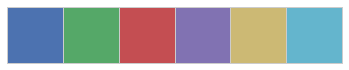

In [28]:
colors = sns.color_palette()
sns.palplot(colors)

For each birth cohort, plot the percentage of Nones as a function of age.

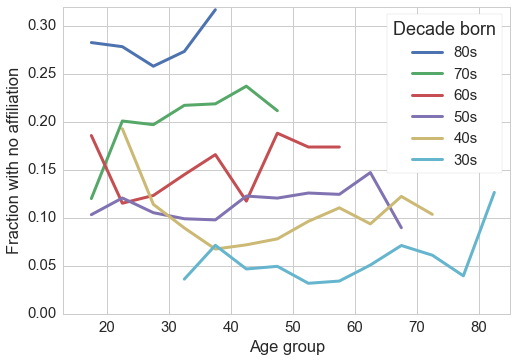

In [29]:
options = dict(alpha=1)

thinkplot.preplot(6)
thinkplot.plot(percent_none.loc[1980], label='80s', color=colors[0], **options)
thinkplot.plot(percent_none.loc[1970], label='70s', color=colors[1], **options)
thinkplot.plot(percent_none.loc[1960], label='60s', color=colors[2], **options)
thinkplot.plot(percent_none.loc[1950], label='50s', color=colors[3], **options)
thinkplot.plot(percent_none.loc[1940], label='40s', color=colors[4], **options)
thinkplot.plot(percent_none.loc[1930], label='30s', color=colors[5], **options)

xlabel = 'Age group'
ylabel = 'Fraction with no affiliation'
axis = [13, 85, 0, 0.32]

thinkplot.config(xlabel=xlabel, ylabel=ylabel, axis=axis, legend=True)
plt.gca().get_legend().set(title='Decade born');

Same as the previous, but as a multi-plot.

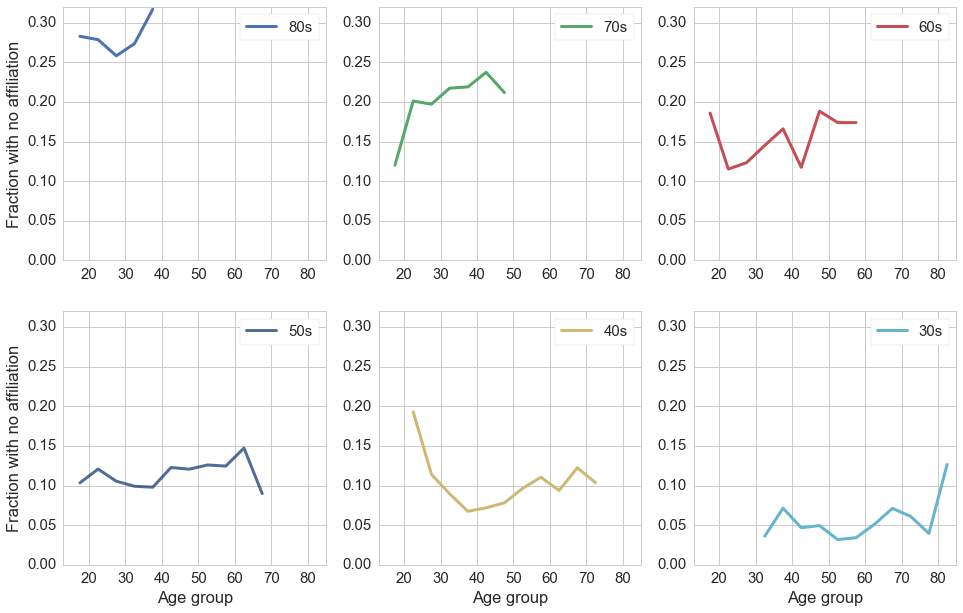

In [30]:
thinkplot.preplot(num=6, rows=2, cols=3)
thinkplot.subplot(1)
thinkplot.plot(percent_none.loc[1980], label='80s', color=colors[0], **options)
thinkplot.config(ylabel=ylabel, axis=axis)

thinkplot.subplot(2)
thinkplot.plot(percent_none.loc[1970], label='70s', color=colors[1], **options)
thinkplot.config(axis=axis)

thinkplot.subplot(3)
thinkplot.plot(percent_none.loc[1960], label='60s', color=colors[2], **options)
thinkplot.config(axis=axis)

thinkplot.subplot(4)
thinkplot.plot(percent_none.loc[1950], label='50s')
thinkplot.config(xlabel=xlabel, ylabel=ylabel, axis=axis, color=colors[3], **options)

thinkplot.subplot(5)
thinkplot.plot(percent_none.loc[1940], label='40s', color=colors[4], **options)
thinkplot.config(xlabel=xlabel, axis=axis)

thinkplot.subplot(6)
thinkplot.plot(percent_none.loc[1930], label='30s', color=colors[5], **options)
thinkplot.config(xlabel=xlabel, axis=axis)

In [31]:
def center_factors(df):
    """Center factors around their means.
    
    df: DataFrame
    """
    df['cohort66'] = df.cohort - 1966
    df['cohort662'] = df.cohort66**2 / 1966
    df['age47'] = df.age - 47
    df['age472'] = df.age47**2 / 47

In [32]:
center_factors(sample)

In [33]:
formula = 'prot ~ cohort66 + cohort662 + age47 + age472'
results = smf.logit(formula, data=sample).fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.664303
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   prot   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61990
Method:                           MLE   Df Model:                            4
Date:                Mon, 29 May 2017   Pseudo R-squ.:                 0.02124
Time:                        13:44:02   Log-Likelihood:                -41183.
converged:                       True   LL-Null:                       -42077.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0815      0.017      4.937      0.000       0.049       0.114
cohort66      -0.0189      0.001    -21.322      0.000      -0.021      -0.017
cohort662     -0.0694      0.036     -1.912      0.056      -0.141       0.002
age47         -0.0009      0.001     -1.170      0.242      -0.002       0.001
age472        -0.0034      0.001     -2.330      0.020      -0.006      -0.001
==============================================================================
"""

In [34]:
formula = 'cath ~ cohort66 + cohort662 + age47 + age472'
results = smf.logit(formula, data=sample).fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.566580
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   cath   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61990
Method:                           MLE   Df Model:                            4
Date:                Mon, 29 May 2017   Pseudo R-squ.:                0.001998
Time:                        13:44:03   Log-Likelihood:                -35125.
converged:                       True   LL-Null:                       -35195.
                                        LLR p-value:                 2.027e-29
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1139      0.019    -59.413      0.000      -1.151      -1.077
cohort66      -0.0058      0.001     -5.809      0.000      -0.008      -0.004
cohort662     -0.2824      0.040     -6.980      0.000      -0.362      -0.203
age47         -0.0053      0.001     -6.106      0.000      -0.007      -0.004
age472         0.0051      0.002      3.125      0.002       0.002       0.008
==============================================================================
"""

In [35]:
formula = 'none ~ cohort66 + cohort662 + age47 + age472'
results = smf.logit(formula, data=sample).fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.332135
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   none   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61990
Method:                           MLE   Df Model:                            4
Date:                Mon, 29 May 2017   Pseudo R-squ.:                 0.06358
Time:                        13:44:03   Log-Likelihood:                -20591.
converged:                       True   LL-Null:                       -21989.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.5459      0.024    -64.474      0.000      -1.593      -1.499
cohort66       0.0399      0.001     32.692      0.000       0.037       0.042
cohort662     -0.1790      0.066     -2.695      0.007      -0.309      -0.049
age47          0.0123      0.001      9.315      0.000       0.010       0.015
age472         0.0091      0.003      3.533      0.000       0.004       0.014
==============================================================================
"""

In [36]:
formula = 'other ~ cohort66 + cohort662 + age47 + age472'
results = smf.logit(formula, data=sample).fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.187014
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  other   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61990
Method:                           MLE   Df Model:                            4
Date:                Mon, 29 May 2017   Pseudo R-squ.:                0.003649
Time:                        13:44:04   Log-Likelihood:                -11594.
converged:                       True   LL-Null:                       -11636.
                                        LLR p-value:                 1.576e-17
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.8014      0.037    -76.012      0.000      -2.874      -2.729
cohort66       0.0133      0.002      6.756      0.000       0.009       0.017
cohort662      0.1129      0.083      1.358      0.175      -0.050       0.276
age47          0.0057      0.002      3.072      0.002       0.002       0.009
age472        -0.0067      0.004     -1.894      0.058      -0.014       0.000
==============================================================================
"""

## Generational replacement

Choose colors

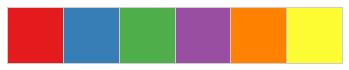

In [37]:
RED, BLUE, GREEN, PURPLE, ORANGE, YELLOW = sns.color_palette('Set1')
sns.palplot(sns.color_palette('Set1'))

In [38]:
def make_series_seq(grouped, varnames):
    """Compute the percentage in each category.
    
    grouped: GroupBy object with one-hots for each category
    varnames: list of string column names
    
    returns: list of Series
    """
    return [grouped[var].mean() * 100 for var in varnames]

def plot_series_seq(series_seq, colors, labels):
    """Plots Series objects.
    
    series_seq: list of Series
    colors: list of string colors
    labels: list of string labels
    """
    for series, color, label in zip(series_seq, colors, labels):
        thinkplot.plot(series, color=color, label=label)

In [82]:
def plot_relig(grouped, varnames):
    """Plot one line for each religious group.
    
    grouped: GroupBy object with one-hots for each religious group
    """
    colors = [ORANGE, GREEN, RED, BLUE]
    labels = ['Protestant', 'Catholic', 'None', 'Other']
    series_seq = make_series_seq(grouped, varnames)
    plot_series_seq(series_seq, colors, labels)

Plot the percentage in each religious group as a function of interview year.

In [83]:
grouped_year = sample.groupby(['year'])
grouped_year.none.count()

year
1972    1603
1973    1496
1974    1477
1975    1483
1976    1491
1977    1516
1978    1522
1980    1456
1982    1837
1983    1588
1984    1456
1985    1522
1986    1460
1987    1802
1988    1476
1989    1530
1990    1367
1991    1513
1993    1592
1994    2976
1996    2894
1998    2792
2000    2805
2002    2735
2004    2792
2006    4468
2008    2004
2010    2028
2012    1962
2014    2513
2016    2839
Name: none, dtype: int64

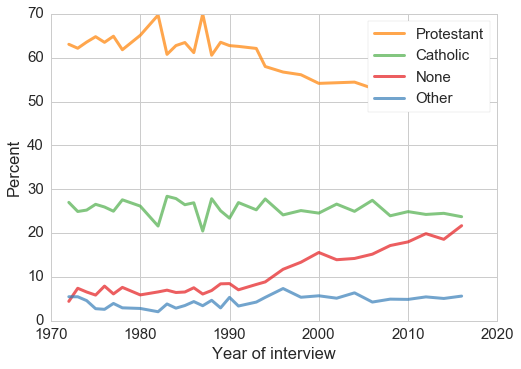

In [84]:
plot_relig(grouped_year, varnames)
thinkplot.config(xlabel='Year of interview', ylabel='Percent')

In [85]:
grouped_age = sample.groupby(['age_group'])
grouped_age.none.count()

age_group
17.5    1492
22.5    6350
27.5    6567
32.5    6358
37.5    6103
42.5    6011
47.5    5829
52.5    5243
57.5    4650
62.5    3953
67.5    3306
72.5    2527
77.5    1825
82.5    1079
87.5     702
Name: none, dtype: int64

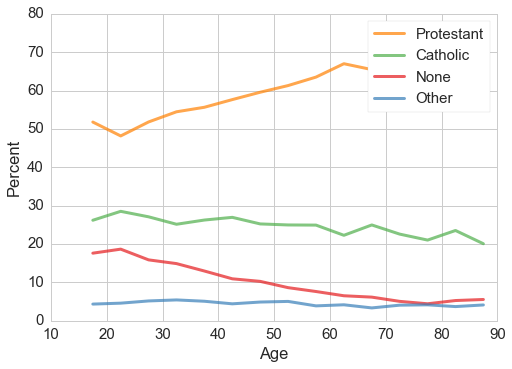

In [86]:
plot_relig(grouped_age, varnames)
thinkplot.config(xlabel='Age', ylabel='Percent')

Plot the percentage in each religious group as a function of birth cohort.

In [87]:
grouped_cohort = sample.groupby(['cohort5'])
grouped_cohort.relig.count()

cohort5
1882.5       7
1887.5      38
1892.5     131
1897.5     336
1902.5     628
1907.5    1072
1912.5    1531
1917.5    2174
1922.5    2690
1927.5    3214
1932.5    3191
1937.5    3629
1942.5    4598
1947.5    5614
1952.5    6458
1957.5    6522
1962.5    5492
1967.5    4249
1972.5    3488
1977.5    2718
1982.5    2046
1987.5    1310
1992.5     650
1997.5     209
Name: relig, dtype: int64

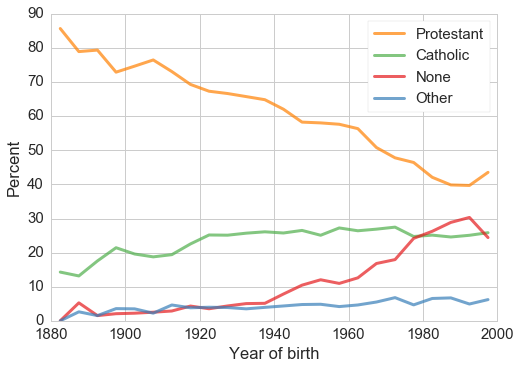

In [88]:
plot_relig(grouped_cohort, varnames)
thinkplot.config(xlabel='Year of birth', ylabel='Percent')

Before running models, center the factors we're planning to use.

In [89]:
def center_factors(df):
    """Center factors around their means.
    
    Add centered factors for the model.
    
    df: DataFrame
    cohort: Series
    age: Series
    """
    df['c'] = df.cohort - 1966
    df['c2'] = df.c**2
    df['a'] = df.age - 47
    df['a2'] = df.a**2
    df['ac'] = df.a * df.c

In [90]:
center_factors(sample)
sample.head()

,year,conclerg,bible,cohort,age,wtssall,ballot,relig,educ,id_,...,relig4,cohort66,cohort662,age47,age472,c,c2,a,a2,ac
0,1972,NaN,NaN,1924.0,48.0,1.3339,0,1.0,6,1425,...,1.0,-42.0,0.897253,1.0,0.021277,-42.0,1764.0,1.0,1.0,-42.0
1,1972,NaN,NaN,1948.0,24.0,0.8893,0,1.0,14,450,...,1.0,-18.0,0.164802,-23.0,11.255319,-18.0,324.0,-23.0,529.0,414.0
2,1972,NaN,NaN,1950.0,22.0,3.5571,0,1.0,16,1382,...,1.0,-16.0,0.130214,-25.0,13.297872,-16.0,256.0,-25.0,625.0,400.0
3,1972,NaN,NaN,1938.0,34.0,0.8893,0,1.0,16,1551,...,1.0,-28.0,0.398779,-13.0,3.595745,-28.0,784.0,-13.0,169.0,364.0
4,1972,NaN,NaN,1914.0,58.0,1.3339,0,1.0,12,1368,...,1.0,-52.0,1.375381,11.0,2.574468,-52.0,2704.0,11.0,121.0,-572.0


Run logistic regression to fit models to each religious group.

In [91]:
def make_model(df, var):
    """Fit a logistic regression model.
    
    df: DataFrame
    var: string name of dependent variable
    """
    formula = var + ' ~ c + c2 + a + a2 + ac'
    return smf.logit(formula, data=df).fit()

In [92]:
make_model(sample, 'prot').summary()

Optimization terminated successfully.
         Current function value: 0.664080
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   prot   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61989
Method:                           MLE   Df Model:                            5
Date:                Mon, 29 May 2017   Pseudo R-squ.:                 0.02157
Time:                        13:51:34   Log-Likelihood:                -41170.
converged:                       True   LL-Null:                       -42077.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0283      0.019      1.462      0.144      -0.010       0.066
c             -0.0290      0.002    -13.722      0.000      -0.033      -0.025
c2            -0.0003   5.32e-05     -5.602      0.000      -0.000      -0.000
a             -0.0119      0.002     -5.343      0.000      -0.016      -0.008
a2            -0.0004   6.63e-05     -5.749      0.000      -0.001      -0.000
ac            -0.0006      0.000     -5.266      0.000      -0.001      -0.000
==============================================================================
"""

In [93]:
make_model(sample, 'cath').summary()

Optimization terminated successfully.
         Current function value: 0.566571
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   cath   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61989
Method:                           MLE   Df Model:                            5
Date:                Mon, 29 May 2017   Pseudo R-squ.:                0.002015
Time:                        13:51:35   Log-Likelihood:                -35125.
converged:                       True   LL-Null:                       -35195.
                                        LLR p-value:                 7.218e-29
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1011      0.022    -49.851      0.000      -1.144      -1.058
c             -0.0034      0.002     -1.444      0.149      -0.008       0.001
c2         -8.296e-05   5.94e-05     -1.396      0.163      -0.000    3.35e-05
a             -0.0027      0.003     -1.097      0.273      -0.008       0.002
a2             0.0002   7.38e-05      2.424      0.015    3.43e-05       0.000
ac             0.0001      0.000      1.088      0.276      -0.000       0.000
==============================================================================
"""

In [94]:
make_model(sample, 'none').summary()

Optimization terminated successfully.
         Current function value: 0.331898
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   none   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61989
Method:                           MLE   Df Model:                            5
Date:                Mon, 29 May 2017   Pseudo R-squ.:                 0.06424
Time:                        13:51:36   Log-Likelihood:                -20576.
converged:                       True   LL-Null:                       -21989.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.4779      0.027    -55.141      0.000      -1.530      -1.425
c              0.0554      0.003     17.874      0.000       0.049       0.061
c2             0.0003    8.6e-05      3.963      0.000       0.000       0.001
a              0.0288      0.003      8.735      0.000       0.022       0.035
a2             0.0007      0.000      6.529      0.000       0.000       0.001
ac             0.0010      0.000      5.456      0.000       0.001       0.001
==============================================================================
"""

In [95]:
make_model(sample, 'other').summary()

Optimization terminated successfully.
         Current function value: 0.187000
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  other   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61989
Method:                           MLE   Df Model:                            5
Date:                Mon, 29 May 2017   Pseudo R-squ.:                0.003726
Time:                        13:51:38   Log-Likelihood:                -11593.
converged:                       True   LL-Null:                       -11636.
                                        LLR p-value:                 3.285e-17
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.8302      0.043    -65.902      0.000      -2.914      -2.746
c              0.0075      0.005      1.567      0.117      -0.002       0.017
c2         -9.759e-05      0.000     -0.790      0.430      -0.000       0.000
a             -0.0007      0.005     -0.139      0.889      -0.011       0.009
a2            -0.0003      0.000     -2.059      0.039      -0.001    -1.6e-05
ac            -0.0003      0.000     -1.335      0.182      -0.001       0.000
==============================================================================
"""

In [96]:
formula = 'relig4 ~ c + c2 + a + a2 + ac'
model = smf.mnlogit(formula, data=sample).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 1.024421
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                 relig4   No. Observations:                61995
Model:                        MNLogit   Df Residuals:                    61977
Method:                           MLE   Df Model:                           15
Date:                Mon, 29 May 2017   Pseudo R-squ.:                 0.02633
Time:                        13:51:41   Log-Likelihood:                -63509.
converged:                       True   LL-Null:                       -65226.
                                        LLR p-value:                     0.000
==============================================================================
  relig4=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.7049      0.023    -30.252      0.000      -0.751      -0.659
c              0.0111      0.002      4.441      0.000       0.006       0.016
c2             0.0001   6.19e-05      1.655      0.098   -1.88e-05       0.000
a              0.0032      0.003      1.224      0.221      -0.002       0.008
a2             0.0003   7.63e-05      3.792      0.000       0.000       0.000
ac             0.0004      0.000      2.757      0.006       0.000       0.001
------------------------------------------------------------------------------
  relig4=3       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.2047      0.044    -50.242      0.000      -2.291      -2.119
c              0.0209      0.005      4.283      0.000       0.011       0.030
c2          7.538e-05      0.000      0.600      0.549      -0.000       0.000
a              0.0046      0.005      0.880      0.379      -0.006       0.015
a2            -0.0002      0.000     -0.944      0.345      -0.000       0.000
ac         -7.429e-05      0.000     -0.282      0.778      -0.001       0.000
------------------------------------------------------------------------------
  relig4=4       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0050      0.028    -35.843      0.000      -1.060      -0.950
c              0.0602      0.003     18.676      0.000       0.054       0.067
c2             0.0004   8.87e-05      4.404      0.000       0.000       0.001
a              0.0301      0.003      8.799      0.000       0.023       0.037
a2             0.0008      0.000      7.092      0.000       0.001       0.001
ac             0.0011      0.000      5.884      0.000       0.001       0.001
==============================================================================
"""

## Predict population

Predict future generations based on the models.

In [97]:
def predict_population(df, model_seq, year):
    """Make a prediction based on a fitted model.
    
    ???
    
    returns: Series that maps year of birth to predicted percentages
    """
    # TODO: consider resampling age and using
    # binomial rather than mean
    # age = thinkstats2.Resample(sample.age)
    age = df.loc[df.year>=2016, 'age']
    cohort = year - age
    df = pd.DataFrame(dict(cohort=cohort, age=age))
    center_factors(df)
    
    pred = [results.predict(df).mean()
            for results in model_seq]
    return pd.Series(pred, index=varnames) * 100

In [98]:
model_seq = [make_model(sample, var) for var in varnames ]

Optimization terminated successfully.
         Current function value: 0.664080
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.331898
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.187000
         Iterations 7


In [99]:
pred = predict_population(sample, model_seq, 2016)
print(sum(pred))
pred

100.481164719


prot     48.093990
cath     24.556820
none     22.262285
other     5.568070
dtype: float64

In [100]:
pred = predict_population(sample, model_seq, 2026)
print(sum(pred))
pred

103.50611105


prot     39.982252
cath     23.760899
none     33.861170
other     5.901791
dtype: float64

In [101]:
pred = predict_population(sample, model_seq, 2036)
print(sum(pred))
pred

109.579124218


prot     31.113600
cath     22.719661
none     49.601811
other     6.144053
dtype: float64

In [102]:
def predict_by_year(sample, model_seq, years):
    """Make predictions by year.
    
    sample: DataFrame
    model_seq: list of fitted models
    years: list of years to generate predictions for
    """
    df = pd.DataFrame(columns=varnames)
    for year in years:
        df.loc[year] = predict_population(sample, model_seq, year)
    return df

In [103]:
years = np.arange(1972, 2040)
df = predict_by_year(sample, model_seq, years)

In [226]:
def plot_predictions(series_seq, colors):
    """Plot a sequence of series.
    
    series_seq: list of series
    """
    alpha = 0.3
    for series, color in zip(series_seq, colors):
        thinkplot.plot(series, color=color, alpha=alpha)

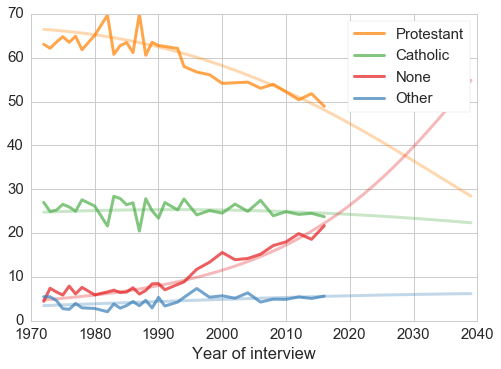

In [123]:
series_seq = [df[var] for var in varnames]
relig_colors = [ORANGE, GREEN, RED, BLUE]

plot_predictions(series_seq, relig_colors)
plot_relig(grouped_year, varnames)
thinkplot.config(xlabel='Year of interview', loc='upper right')

## Multinomial models

In [108]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# solvers are newton-cg, sag, and lbfgs

model = LogisticRegression(multi_class='multinomial', solver='newton-cg')
y = sample.relig4
X = sample[['c', 'a']].values
model.fit(X, y)
model.predict_proba(X).mean(axis=0)

array([ 0.58472457,  0.25495604,  0.04637471,  0.11394467])

In [109]:
y = sample.relig4
X = sample[['c', 'a', 'c2', 'a2', 'ac']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=42)

model = LogisticRegression(multi_class='multinomial', solver='newton-cg')
model.fit(X_train, y_train)
pop_pred = model.predict_proba(X_test).mean(axis=0)
pop_pred

array([ 0.58069418,  0.25780476,  0.04643905,  0.11506201])

In [110]:
pmf = thinkstats2.Pmf(y_test)
pop_actual = np.array(pmf.Probs([1, 2, 3, 4]))
pop_actual

array([ 0.58722478,  0.25297739,  0.04637471,  0.11342313])

In [111]:
from sklearn.metrics import mutual_info_score

def kl_divergence(p, q):
    return sum(p * np.log(p/q))

In [112]:
kl_divergence(pop_actual, pop_pred)

9.3838156511136033e-05

In [194]:
def make_multi_model(df, var, factors):
    """Fit a logistic regression model.
    
    df: DataFrame
    var: string name of dependent variable
    """
    model = LogisticRegression(multi_class='multinomial', solver='newton-cg')
    
    nonull = df.dropna(subset=factors + [var])

    X = nonull[factors].values
    y = nonull[var].values
    model.fit(X, y)
    return model

In [196]:
def predict_multi_model(age, model, year, factors, index):
    """Make a prediction based on a fitted model.
    
    ???
    
    returns: Series that maps year of birth to predicted percentages
    """
    # TODO: consider resampling age and using
    # binomial rather than mean
    # age = thinkstats2.Resample(sample.age)
    cohort = year - age
    df = pd.DataFrame(dict(cohort=cohort, age=age))
    center_factors(df)
    X = df[factors].values
    pred = model.predict_proba(X).mean(axis=0)
    return pd.Series(pred, index=index) * 100

In [197]:
train_year = 2016
train = sample[sample.year <= train_year]

In [198]:
factors = ['a', 'c']
model = make_multi_model(train, 'relig4', factors)

In [199]:
age = sample.loc[sample.year==train_year, 'age']
index = ['prot', 'cath', 'other', 'none']

predict_multi_model(age, model, 2016, factors, index)

prot     49.602331
cath     24.129378
other     5.615143
none     20.653147
dtype: float64

In [200]:
predict_multi_model(age, model, 2026, factors, index)

prot     43.719699
cath     22.602811
other     5.922945
none     27.754545
dtype: float64

In [201]:
predict_multi_model(age, model, 2036, factors, index)

prot     37.383256
cath     20.515909
other     6.052475
none     36.048360
dtype: float64

In [202]:
def predict_by_year_multi(age, model, years, factors, index):
    """Make predictions by year.
    
    age: Series of ages
    model_seq: list of fitted models
    years: list of years to generate predictions for
    """
    pred = pd.DataFrame(columns=varnames)
    for year in years:
        pred.loc[year] = predict_multi_model(age, model, year, factors, index)
    return pred

In [203]:
years = np.arange(1972, 2040)
pred = predict_by_year_multi(age, model, years, factors, index)

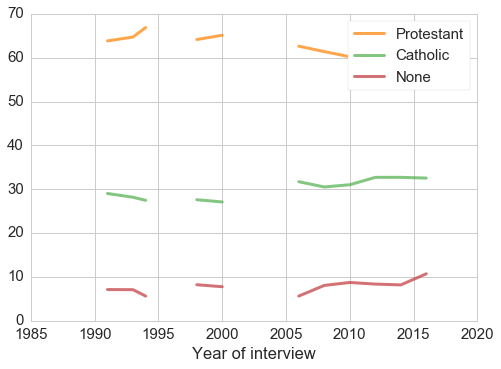

In [204]:
series_seq = [pred[var] for var in varnames]
plot_predictions(series_seq, relig_colors)

plot_relig(grouped_year, varnames)
thinkplot.config(xlabel='Year of interview', loc='upper right')

In [211]:
def make_multi_pred(df, var, varnames, train_year, years, factors, index):
    train = df[df.year <= train_year]
    age = df.loc[df.year==train_year, 'age']

    model = make_multi_model(train, var, factors)
    
    pred = pd.DataFrame(columns=varnames)
    for year in years:
        pred.loc[year] = predict_multi_model(age, model, year, factors, index)
    return pred

def plot_multi_pred(df, pred, varnames, colors):
    series_seq = [pred[var] for var in varnames]
    plot_predictions(series_seq, colors)
    thinkplot.config(xlabel='Year of interview', loc='upper right')

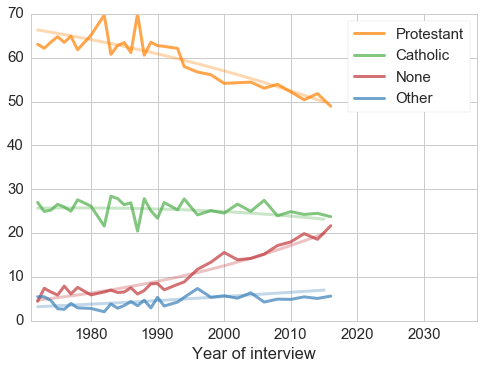

In [212]:
var = 'relig4'
varnames = ['prot', 'cath', 'none', 'other']
colors = [ORANGE, GREEN, RED, BLUE]
train_year = 2000
years = np.arange(1972, 2016)
factors = ['a', 'c']
index = ['prot', 'cath', 'other', 'none']

pred = make_multi_pred(sample, var, varnames, train_year, years, factors, index)
plot_multi_pred(sample, pred, varnames, colors)
plot_relig(grouped_year, varnames)
thinkplot.config(xlim=[1971, 2038])

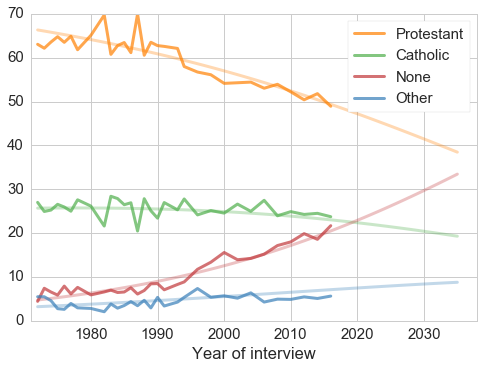

In [208]:
train_year = 2000
years = np.arange(1972, 2036)

pred = make_multi_pred(sample, var, varnames, train_year, years, factors, index)
plot_multi_pred(sample, pred, varnames, colors)
thinkplot.config(xlim=[1971, 2038])

In [174]:
stop here

SyntaxError: invalid syntax (<ipython-input-174-f9ef205a8f26>, line 1)

## Belief in God

In [177]:
varnames = ['strongbelief', 'belief', 'nobelief']

def create_belief_vars(df):
    """Creates columns for belief categories.
    
    df: DataFrame
    """
    df['nobelief'] = (df.god.isin([1, 2]))
    df['belief'] = (df.god.isin([3, 4, 5]))
    df['strongbelief'] = (df.god.isin([6]))
    
    df['belief3'] = df.god.copy()
    df.belief3.replace([1, 2], 1, inplace=True)
    df.belief3.replace([3, 4, 5], 2, inplace=True)
    df.belief3.replace([6], 3, inplace=True)

    df.loc[df.god.isnull(), varnames + ['belief3']] = np.nan
    
create_belief_vars(sample)

In [227]:
RED, PINK, _, _, LTBLUE, DKBLUE = sns.color_palette('RdBu', 6)
belief_colors = [BLUE, PURPLE, RED]

In [228]:
def plot_beliefs(grouped, varnames):
    """Plot belief categories.
    
    grouped: GroupBy object
    """
    colors = [BLUE, PURPLE, RED]
    labels = ['Strong belief', 'Belief', 'No belief']
    series_seq = make_series_seq(grouped, varnames)
    plot_series_seq(series_seq, colors, labels)

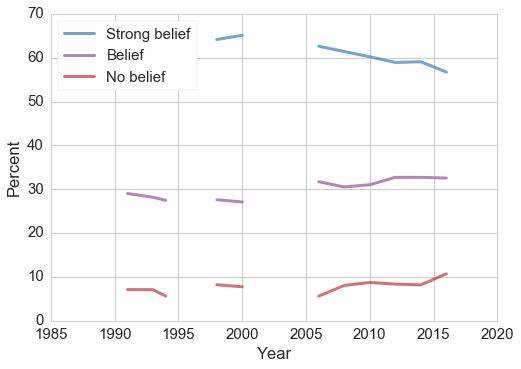

In [229]:
plot_beliefs(grouped_year, varnames)
thinkplot.config(xlabel='Year', ylabel='Percent', loc='upper left')

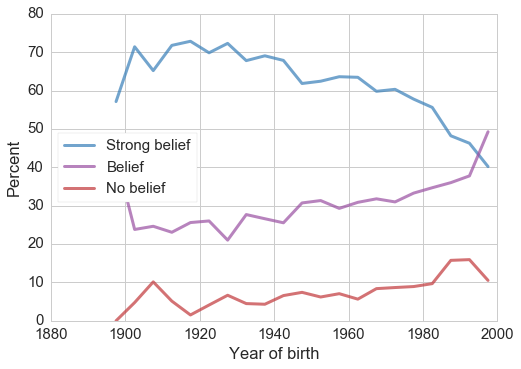

In [230]:
plot_beliefs(grouped_cohort, varnames)
thinkplot.config(xlabel='Year of birth', ylabel='Percent', loc='center left')

In [231]:
make_model(sample, 'strongbelief').summary()

Optimization terminated successfully.
         Current function value: 0.658402
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           strongbelief   No. Observations:                22363
Model:                          Logit   Df Residuals:                    22357
Method:                           MLE   Df Model:                            5
Date:                Mon, 29 May 2017   Pseudo R-squ.:                 0.01169
Time:                        14:26:10   Log-Likelihood:                -14724.
converged:                       True   LL-Null:                       -14898.
                                        LLR p-value:                 3.933e-73
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4351      0.023     18.897      0.000       0.390       0.480
c             -0.0314      0.005     -6.722      0.000      -0.040      -0.022
c2            -0.0008      0.000     -3.953      0.000      -0.001      -0.000
a             -0.0179      0.005     -3.779      0.000      -0.027      -0.009
a2            -0.0011      0.000     -4.794      0.000      -0.002      -0.001
ac            -0.0017      0.000     -3.939      0.000      -0.003      -0.001
==============================================================================
"""

In [232]:
make_model(sample, 'belief').summary()

Optimization terminated successfully.
         Current function value: 0.613792
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 belief   No. Observations:                22363
Model:                          Logit   Df Residuals:                    22357
Method:                           MLE   Df Model:                            5
Date:                Mon, 29 May 2017   Pseudo R-squ.:                0.004657
Time:                        14:26:16   Log-Likelihood:                -13726.
converged:                       True   LL-Null:                       -13790.
                                        LLR p-value:                 5.108e-26
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.7772      0.024    -32.138      0.000      -0.825      -0.730
c              0.0206      0.005      4.208      0.000       0.011       0.030
c2             0.0006      0.000      2.507      0.012       0.000       0.001
a              0.0126      0.005      2.531      0.011       0.003       0.022
a2             0.0007      0.000      3.138      0.002       0.000       0.001
ac             0.0012      0.000      2.675      0.007       0.000       0.002
==============================================================================
"""

In [233]:
make_model(sample, 'nobelief').summary()

Optimization terminated successfully.
         Current function value: 0.267899
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               nobelief   No. Observations:                22363
Model:                          Logit   Df Residuals:                    22357
Method:                           MLE   Df Model:                            5
Date:                Mon, 29 May 2017   Pseudo R-squ.:                 0.01687
Time:                        14:26:17   Log-Likelihood:                -5991.0
converged:                       True   LL-Null:                       -6093.8
                                        LLR p-value:                 1.819e-42
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.4931      0.042    -59.288      0.000      -2.575      -2.411
c              0.0397      0.008      4.779      0.000       0.023       0.056
c2             0.0010      0.000      2.532      0.011       0.000       0.002
a              0.0220      0.009      2.585      0.010       0.005       0.039
a2             0.0014      0.000      3.357      0.001       0.001       0.002
ac             0.0020      0.001      2.517      0.012       0.000       0.004
==============================================================================
"""

In [249]:
model_seq = [make_model(sample, var) for var in varnames]

Optimization terminated successfully.
         Current function value: 0.658402
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.613792
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.267899
         Iterations 7


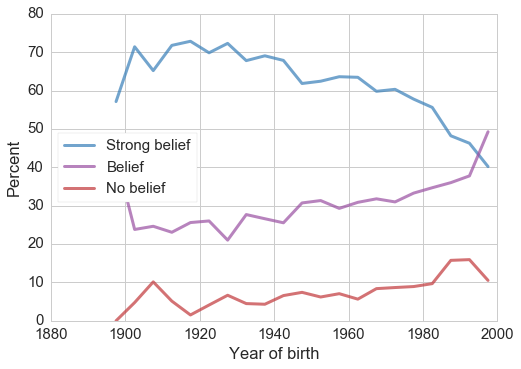

In [251]:
plot_beliefs(grouped_cohort, varnames)
thinkplot.config(xlabel='Year of birth', ylabel='Percent', loc='center left')

In [191]:
formula = 'belief3 ~ c + c2 + a + a2 + ac'
model = smf.mnlogit(formula, data=sample).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.850065
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                belief3   No. Observations:                22363
Model:                        MNLogit   Df Residuals:                    22351
Method:                           MLE   Df Model:                           10
Date:                Mon, 29 May 2017   Pseudo R-squ.:                 0.01079
Time:                        14:13:20   Log-Likelihood:                -19010.
converged:                       True   LL-Null:                       -19217.
                                        LLR p-value:                 6.617e-83
==============================================================================
 belief3=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4187      0.045     31.497      0.000       1.330       1.507
c             -0.0224      0.009     -2.512      0.012      -0.040      -0.005
c2            -0.0005      0.000     -1.249      0.212      -0.001       0.000
a             -0.0117      0.009     -1.281      0.200      -0.030       0.006
a2            -0.0008      0.000     -1.738      0.082      -0.002    9.85e-05
ac            -0.0010      0.001     -1.181      0.237      -0.003       0.001
------------------------------------------------------------------------------
 belief3=3       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0725      0.043     48.320      0.000       1.988       2.157
c             -0.0491      0.009     -5.775      0.000      -0.066      -0.032
c2            -0.0013      0.000     -3.156      0.002      -0.002      -0.000
a             -0.0273      0.009     -3.143      0.002      -0.044      -0.010
a2            -0.0017      0.000     -4.044      0.000      -0.003      -0.001
ac            -0.0025      0.001     -3.113      0.002      -0.004      -0.001
==============================================================================
"""

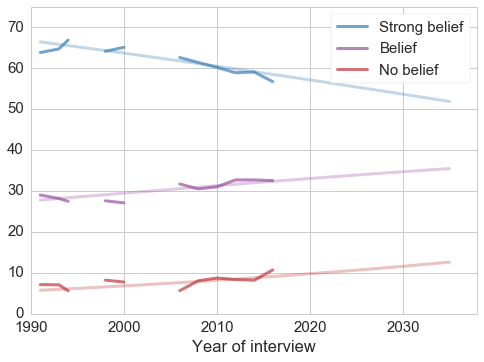

In [245]:
var = 'belief3'
varnames = ['strongbelief', 'belief', 'nobelief']
colors = [RED, PURPLE, BLUE]
train_year = 2016
years = np.arange(1991, 2036)
factors = ['a', 'c']
index = varnames

pred = make_multi_pred(sample, var, varnames, train_year, years, factors, index)
plot_multi_pred(sample, pred, varnames, colors)
plot_beliefs(grouped_year, varnames)

thinkplot.config(xlim=[1990, 2038], ylim=[0, 75])

## Confidence in people running organized religion

As far as the people running this institution [organized religion] are concerned, would you say you have a great deal of confidence, only some confidence, or hardly any confidence at all in them?

1. A great deal
2. Only some
3. Hardly any



In [253]:
sum(sample.conclerg.isnull())

21405

In [254]:
varnames = ['confident', 'someconf', 'noconf']

def create_conf_vars(df):
    """Creates columns for confidence in religion categories.
    
    df: DataFrame
    """
    df['confident'] = (df.conclerg == 1)
    df['someconf'] = (df.conclerg == 2)
    df['noconf'] = (df.conclerg == 3)

    df.loc[df.conclerg.isnull(), varnames] = np.nan
    
create_conf_vars(sample)

In [260]:
def plot_conf(grouped, colors):
    """Plot confidence in religion categories.
    
    grouped: GroupBy object
    """
    labels = ['Great deal', 'Only some', 'Hardly any']
    series_seq = make_series_seq(grouped, varnames)
    plot_series_seq(series_seq, colors, labels)

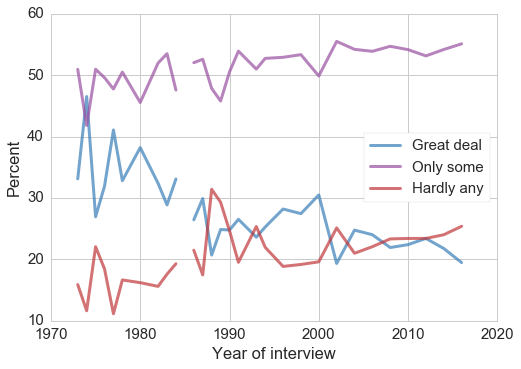

In [262]:
colors = [BLUE, PURPLE, RED]
plot_conf(grouped_year, colors)
thinkplot.config(xlabel='Year of interview', ylabel='Percent', loc='center right')

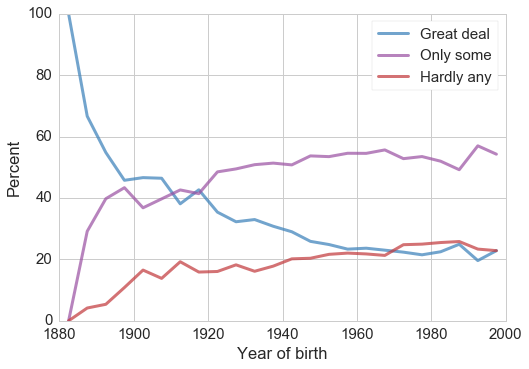

In [263]:
plot_conf(grouped_cohort, colors)
thinkplot.config(xlabel='Year of birth', ylabel='Percent', loc='upper right')

In [264]:
make_model(sample, 'confident').summary()

Optimization terminated successfully.
         Current function value: 0.582928
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              confident   No. Observations:                40590
Model:                          Logit   Df Residuals:                    40584
Method:                           MLE   Df Model:                            5
Date:                Mon, 29 May 2017   Pseudo R-squ.:                 0.01992
Time:                        14:45:53   Log-Likelihood:                -23661.
converged:                       True   LL-Null:                       -24142.
                                        LLR p-value:                1.042e-205
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.4172      0.029    -48.672      0.000      -1.474      -1.360
c             -0.0099      0.003     -3.305      0.001      -0.016      -0.004
c2             0.0002   7.32e-05      3.344      0.001       0.000       0.000
a             -0.0032      0.003     -1.018      0.309      -0.009       0.003
a2             0.0005   8.94e-05      6.021      0.000       0.000       0.001
ac             0.0003      0.000      2.184      0.029    3.38e-05       0.001
==============================================================================
"""

In [265]:
make_model(sample, 'someconf').summary()

Optimization terminated successfully.
         Current function value: 0.689040
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               someconf   No. Observations:                40590
Model:                          Logit   Df Residuals:                    40584
Method:                           MLE   Df Model:                            5
Date:                Mon, 29 May 2017   Pseudo R-squ.:                0.005298
Time:                        14:45:54   Log-Likelihood:                -27968.
converged:                       True   LL-Null:                       -28117.
                                        LLR p-value:                 2.767e-62
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2803      0.024     11.502      0.000       0.233       0.328
c              0.0045      0.003      1.733      0.083      -0.001       0.010
c2         -7.093e-05   6.47e-05     -1.096      0.273      -0.000    5.59e-05
a              0.0035      0.003      1.265      0.206      -0.002       0.009
a2            -0.0002   8.05e-05     -2.615      0.009      -0.000   -5.27e-05
ac          6.319e-05      0.000      0.472      0.637      -0.000       0.000
==============================================================================
"""

In [266]:
make_model(sample, 'noconf').summary()

Optimization terminated successfully.
         Current function value: 0.501739
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 noconf   No. Observations:                40590
Model:                          Logit   Df Residuals:                    40584
Method:                           MLE   Df Model:                            5
Date:                Mon, 29 May 2017   Pseudo R-squ.:                0.006283
Time:                        14:45:55   Log-Likelihood:                -20366.
converged:                       True   LL-Null:                       -20494.
                                        LLR p-value:                 1.325e-53
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1461      0.029    -39.643      0.000      -1.203      -1.089
c              0.0010      0.003      0.318      0.750      -0.005       0.007
c2            -0.0003   8.06e-05     -4.019      0.000      -0.000      -0.000
a             -0.0039      0.003     -1.161      0.245      -0.010       0.003
a2            -0.0004      0.000     -3.924      0.000      -0.001      -0.000
ac            -0.0006      0.000     -3.697      0.000      -0.001      -0.000
==============================================================================
"""

In [268]:
model_seq = [make_model(sample, var) for var in varnames]

Optimization terminated successfully.
         Current function value: 0.582928
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689040
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.501739
         Iterations 5


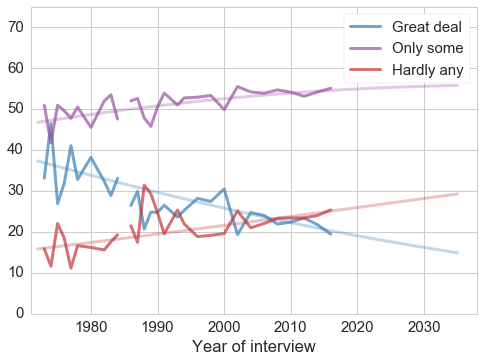

In [278]:
var = 'conclerg'
varnames = ['confident', 'someconf', 'noconf']
colors = [BLUE, PURPLE, RED]
train_year = 2016
years = np.arange(1972, 2036)
factors = ['a', 'c']
index = varnames

pred = make_multi_pred(sample, var, varnames, train_year, years, factors, index)
plot_multi_pred(sample, pred, varnames, colors)
plot_conf(grouped_year, colors)

thinkplot.config(xlim=[1971, 2038], ylim=[0, 75])

## Bible

Which one of these statements comes closest to describing your feelings about the Bible? 

1. The Bible is the actual word of God and is to be taken literally, word for word

2. The Bible is the inspired word of God but not everything should be taken literally, word for word

3. The Bible is an ancient book of fables, legends, history and moral precepts recorded by man

In [279]:
sum(sample.bible.isnull())

29016

In [280]:
varnames = ['word', 'inspired', 'legends']

def create_bible_vars(df):
    """Creates columns for bible interpretation categories.
    
    df: DataFrame
    """
    df['word'] = (df.bible == 1)
    df['inspired'] = (df.bible == 2)
    df['legends'] = (df.bible == 3)

    df.loc[df.bible.isnull(), varnames] = np.nan
    
create_bible_vars(sample)

In [285]:
def plot_bible(grouped, colors):
    """Plot bible interpretation categories.
    
    grouped: GroupBy object
    """
    labels = ['Literal', 'Inspired', 'Legends']
    series_seq = make_series_seq(grouped, varnames)
    plot_series_seq(series_seq, colors, labels)

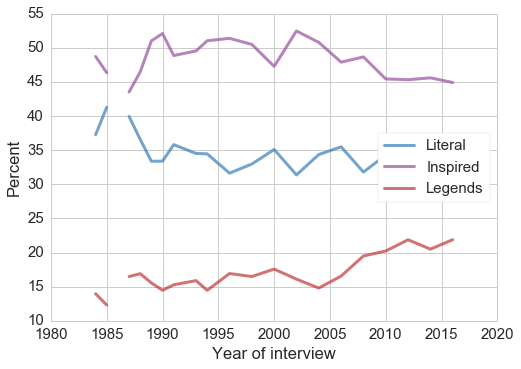

In [286]:
plot_bible(grouped_year, colors)
thinkplot.config(xlabel='Year of interview', ylabel='Percent', loc='center right')

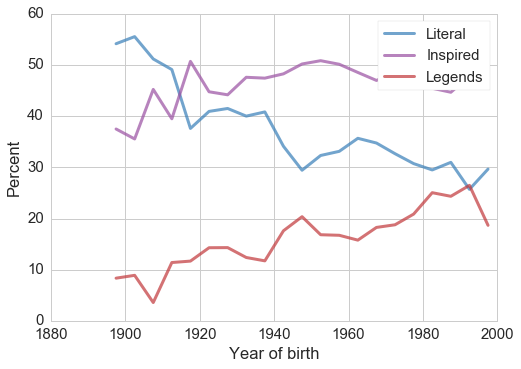

In [287]:
plot_bible(grouped_cohort, colors)
thinkplot.config(xlabel='Year of birth', ylabel='Percent', loc='upper right')

In [288]:
make_model(sample, 'word').summary()

Optimization terminated successfully.
         Current function value: 0.640227
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   word   No. Observations:                32979
Model:                          Logit   Df Residuals:                    32973
Method:                           MLE   Df Model:                            5
Date:                Mon, 29 May 2017   Pseudo R-squ.:                0.004205
Time:                        14:55:49   Log-Likelihood:                -21114.
converged:                       True   LL-Null:                       -21203.
                                        LLR p-value:                 1.233e-36
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.7101      0.023    -31.498      0.000      -0.754      -0.666
c              0.0042      0.004      1.175      0.240      -0.003       0.011
c2             0.0004      0.000      3.002      0.003       0.000       0.001
a              0.0095      0.004      2.583      0.010       0.002       0.017
a2             0.0003      0.000      1.915      0.056   -7.06e-06       0.001
ac             0.0006      0.000      2.262      0.024    8.57e-05       0.001
==============================================================================
"""

In [289]:
make_model(sample, 'inspired').summary()

Optimization terminated successfully.
         Current function value: 0.691267
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               inspired   No. Observations:                32979
Model:                          Logit   Df Residuals:                    32973
Method:                           MLE   Df Model:                            5
Date:                Mon, 29 May 2017   Pseudo R-squ.:                0.001712
Time:                        14:55:50   Log-Likelihood:                -22797.
converged:                       True   LL-Null:                       -22836.
                                        LLR p-value:                 1.993e-15
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1518      0.021     -7.093      0.000      -0.194      -0.110
c             -0.0223      0.003     -6.546      0.000      -0.029      -0.016
c2            -0.0008      0.000     -5.675      0.000      -0.001      -0.000
a             -0.0206      0.004     -5.881      0.000      -0.027      -0.014
a2            -0.0005      0.000     -3.448      0.001      -0.001      -0.000
ac            -0.0012      0.000     -4.489      0.000      -0.002      -0.001
==============================================================================
"""

In [290]:
make_model(sample, 'legends').summary()

Optimization terminated successfully.
         Current function value: 0.461221
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                legends   No. Observations:                32979
Model:                          Logit   Df Residuals:                    32973
Method:                           MLE   Df Model:                            5
Date:                Mon, 29 May 2017   Pseudo R-squ.:                0.007882
Time:                        14:55:51   Log-Likelihood:                -15211.
converged:                       True   LL-Null:                       -15331.
                                        LLR p-value:                 3.362e-50
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.3325      0.027    -49.542      0.000      -1.385      -1.280
c              0.0298      0.004      6.802      0.000       0.021       0.038
c2             0.0006      0.000      3.184      0.001       0.000       0.001
a              0.0197      0.005      4.342      0.000       0.011       0.029
a2             0.0004      0.000      2.019      0.043    1.17e-05       0.001
ac             0.0010      0.000      2.887      0.004       0.000       0.002
==============================================================================
"""

In [293]:
model_seq = [make_model(sample, var) for var in varnames]

Optimization terminated successfully.
         Current function value: 0.640227
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691267
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.461221
         Iterations 6


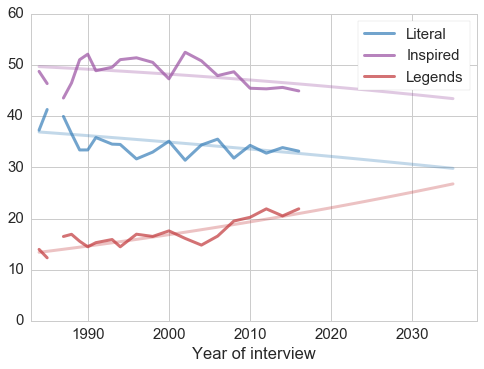

In [299]:
var = 'bible'
varnames = ['word', 'inspired', 'legends']
colors = [BLUE, PURPLE, RED]
train_year = 2016
years = np.arange(1984, 2036)
factors = ['a', 'c']
index = varnames

pred = make_multi_pred(sample, var, varnames, train_year, years, factors, index)
plot_multi_pred(sample, pred, varnames, colors)
plot_bible(grouped_year, colors)

thinkplot.config(xlim=[1983, 2038], ylim=[0, 60])